In [ ]:
import numpy as np
import pandas as pd
import copy
import torch
from LSTM_classification import *

from sklearn.model_selection import train_test_split
import torch.optim as optim

import sys
sys.path.append("../Processing/")  

from utils import *  

In [ ]:
cora = pd.read_csv("./Cora_dataset_new_clsBERT.csv")

for col in ['bert_cls_embedding2']:
    cora[col] = cora[col].apply(parse_embedding_flexible)

In [ ]:
X = np.stack(cora['bert_cls_embedding2'].values)  
y = np.array(cora['topic2'].factorize()[0])  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = LSTMDataset(X_train, y_train)
test_dataset  = LSTMDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [ ]:
input_dim = X.shape[1]       
hidden_dim = 256
output_dim = 7 # number of classes in Cora

model = LSTMClassifier(input_dim, hidden_dim, output_dim)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
patience = 50
to_patience = 0
num_epochs = 500
best_val_acc = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    if to_patience >= patience:
        break
    # Training
    model.train()
    total_train_loss = 0
    correct_train = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == y_batch).sum().item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation 
    model.eval()
    total_val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_val += (preds == y_batch).sum().item()
    
    avg_val_loss = total_val_loss / len(test_loader)
    val_acc = correct_val / len(test_dataset)
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        to_patience = 0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        to_patience += 1

    if epoch % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    

model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "best_model_LST_BERT2.pth")
print(f"Best val accuracy: {best_val_acc:.4f}")


Epoch 1/500 | Train Loss: 1.5328, Train Acc: 0.4187 | Val Loss: 1.2185, Val Acc: 0.5612
Epoch 21/500 | Train Loss: 0.1162, Train Acc: 0.9778 | Val Loss: 1.2997, Val Acc: 0.6814
Epoch 41/500 | Train Loss: 0.0074, Train Acc: 1.0000 | Val Loss: 1.7089, Val Acc: 0.6751
Epoch 61/500 | Train Loss: 0.0022, Train Acc: 1.0000 | Val Loss: 1.8667, Val Acc: 0.6857
Best val accuracy: 0.6983


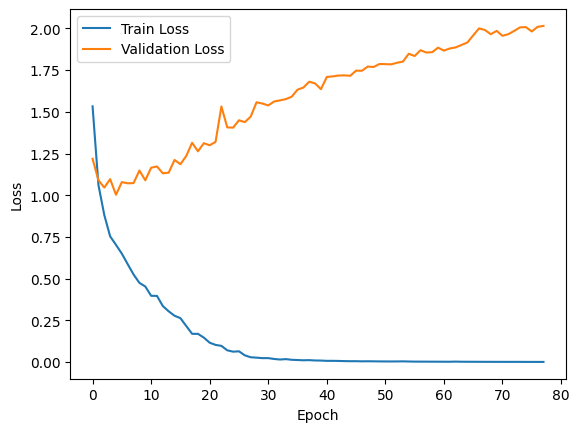

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

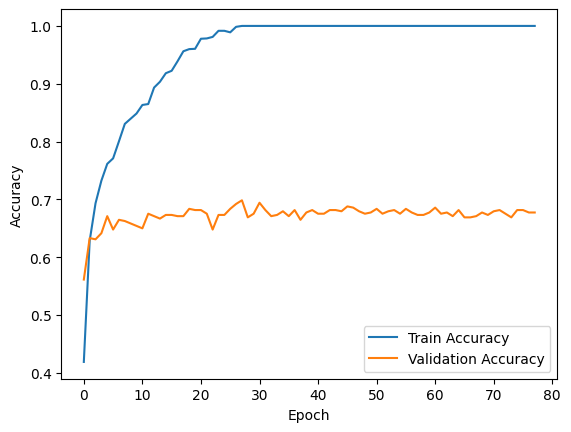

In [12]:
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()